In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importiere Daten

project_person_relations = pd.read_csv("project_person_relations.csv", encoding = "utf-8") # für Anzahl Projekt / Person
people_joined_with_institutions = pd.read_csv("people_joined_with_institutions.csv", encoding = "utf-8") # für top 10 researchers per Uni
project_gender_index = pd.read_csv('data/project_gender_index.csv', encoding = 'utf-8') # für Berechnung des Gender Index je Person / Institution
institution_data = pd.read_csv('data/extracted_institution_data_geocoded.csv', encoding = 'utf-8') # final dataset

In [4]:
# Berechne person_gender_index basierend auf dem Durchschnitt des project_gender_indexes der Projekte, an der die Person teilnimmt

## Füge project_gender_index über project_id zu project_person_data hinzu
project_gender_index['project_id'] = project_gender_index.project_id.astype(int)
project_gender_index_map = project_gender_index.set_index(['project_id']).to_dict()['gender_index']  
project_person_relations['gender_index'] = project_person_relations.set_index('project_id_number').index.map(project_gender_index_map)   

## Gruppiere project_person_data nach Person & Projekten und entferne alle Projekte, für die es keinen project_gender_index gibt
person_gender_index = pd.DataFrame(project_person_relations.groupby(['person_id', 'project_id_number'])['gender_index'].first())
person_gender_index = person_gender_index.dropna() # drop projects that have no gender_index for calculation (basically, we're ignoring the same projects we've ignored before)

## Berechne Durchschnitt von project_gender_index pro Person
person_gender_index = person_gender_index.mean(level=['person_id'])

## Speichere person_gender_index
person_gender_index = person_gender_index.reset_index()
person_gender_index.to_csv('data/person_gender_index.csv')

In [10]:
# Berechne institution_gender_index basierend auf dem Durchschnitt des person_gender_index der Personen, die der Institution angehörig sind

## Entferne alle Zeilen in people_joined_with_institutions, bei denen die institution_id fehlt
print(people_joined_with_institutions['institution_id'].isna().sum())
print(people_joined_with_institutions['institution_id'].notna().sum())
reduced_people_joined_with_institutions = people_joined_with_institutions.dropna(subset=['institution_id'])

## Füge person_gender_index über person_id zu people_joined with_institutions hinzu
institution_gender_index = reduced_people_joined_with_institutions
person_gender_index_map = person_gender_index.set_index(['person_id']).to_dict()['gender_index']  
institution_gender_index['person_gender_index'] = institution_gender_index.set_index('person_id').index.map(person_gender_index_map)

# Gruppiere people_joined_with_institutions nach Institution & Person und entferne alle Personen, für die es keinen person_gender_index gibt
print(institution_gender_index['person_gender_index'].isna().sum())
print(institution_gender_index['person_gender_index'].notna().sum())
institution_gender_index = pd.DataFrame(institution_gender_index.groupby(['institution_id', 'person_id'])['person_gender_index'].first())
institution_gender_index = institution_gender_index.dropna(subset=['person_gender_index'])

## Berechne Durchschnitt von person_gender_index pro Institution
institution_gender_index = institution_gender_index.mean(level=['institution_id'])
institution_gender_index = institution_gender_index.rename(columns={'person_gender_index': 'institution_gender_index'})

## Speichere person_gender_index
institution_gender_index = institution_gender_index.reset_index()
institution_gender_index.to_csv('data/institution_gender_index.csv')

14687
44178
21238
22940


In [6]:
# Erstelle TOP 10 researchers Liste pro Institution

## Gruppiere project_person_data nach Person & Projekten, zähle Anzahl der Projekte 
project_count_per_person = pd.DataFrame(project_person_relations.groupby(['person_id'])['project_id_number'].count())
project_count_per_person = project_count_per_person.rename(columns={'project_id_number': 'project_count'})
project_count_per_person = project_count_per_person.reset_index()

## Füge project_count über person_id zu reduced_people_joined_with_institutions hinzu
institution_people_project_count = reduced_people_joined_with_institutions
project_count_map = project_count_per_person.set_index(['person_id']).to_dict()['project_count']  
institution_people_project_count['project_count'] = institution_people_project_count.set_index('person_id').index.map(project_count_map)

## Berechne Top 10 Researchers nach Anzahl der Projekte
top_researchers_by_projects = pd.DataFrame(institution_people_project_count.groupby(['institution_id', 'person_id'])['project_count'].first())
top_researchers_by_projects = top_researchers_by_projects.sort_values([('project_count')], ascending=False)
top_researchers_by_projects = top_researchers_by_projects.groupby(level=0).apply(lambda df: df.sort_index(by='project_count')[-10:])

## Füge person_gender_index zu top_researchers_by_projects hinzu
top_researchers_by_projects = top_researchers_by_projects.reset_index(level=0, drop=True)
top_researchers_by_projects = top_researchers_by_projects.reset_index()
top_researchers_by_projects['person_gender_index'] = top_researchers_by_projects.set_index('person_id').index.map(person_gender_index_map)

## Speichere Top 10 researchers
top_researchers_by_projects.to_csv('data/top_researchers_by_projects.csv')

# wir könnten hier noch die NaN rauswerfen, allerdings ist es an dieser Stelle durchaus sinnvoll, die auch in der Detailsicht anzuzeigen
#top_researchers_by_projects.dropna(subset=['person_gender_index'])

## Nice to have: Berechne Top 10 Researchers nach Person Gender Index
#top_researchers_by_gender_index = pd.DataFrame(institution_people_project_count.groupby(['institution_id', 'person_id'])['person_gender_index'].first())
#top_researchers_by_gender_index = top_researchers_by_gender_index.dropna(subset=['person_gender_index'])
## In der folgenden Zeile müssten wir dann die 10 Werte pro Institution bekommen, die am nächsten um 0,5 liegen
#top_researchers_by_gender_index = top_researchers_by_gender_index.groupby(level=0).apply(lambda df: df.sort_index(by='person_gender_index')[-10:])

In [7]:
# Berechne Anzahl der Projekte pro Institution (für die Größe der Punkte in der Visualisierung)
## Beachte: in project_institution_relations.csv gibt es zwar auch Beziehungen zwischen Institutionen und Projekten, aber nicht 
## jedes Projekt ist direkt an eine Institution gebunden. Unsere Anzahl von Projekten pro Insitution berechnet sich daher
## aus der Anzahl der Projekte pro Person - und diese Person ist an eine Institution gebunden. Dadurch doppeln/vermehren sich 
## allerdings auch Projekte, wenn mehrere Personen an einer Institution im gleichen Projekt sind. Die Zahl sagt also eher aus, 
## wieviele Personen an einer Institution in wievielen Projekten gefördert wurden.

projects_per_institution = pd.DataFrame(institution_people_project_count.groupby(['institution_id'])['project_count'].sum())
projects_per_institution = projects_per_institution.reset_index()
projects_per_institution = projects_per_institution.rename(columns={'project_count': 'total_projects_count'})

projects_per_institution_map = projects_per_institution.set_index(['institution_id']).to_dict()['total_projects_count']
institution_data['total_projects_count'] = institution_data.set_index('institution_id').index.map(projects_per_institution_map)

institution_data.to_csv('data/extracted_institution_data_geocoded.csv') # final dataset

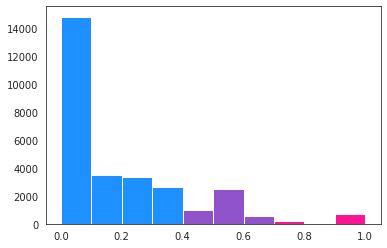

In [7]:
import seaborn as sns

sns.set_style('white')
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(person_gender_index['gender_index'], 10)

for c, p in zip(bins, patches):
    if c >= 0 and c < 0.33:
        plt.setp(p, 'facecolor', 'DodgerBlue')
    elif c >= 0.33 and c < 0.66  :
        plt.setp(p, 'facecolor', '#8f52c9')
    elif c >= 0.66:
        plt.setp(p, 'facecolor', 'DeepPink')

plt.savefig("img/person_gender_index_hist.png")

In [8]:
print(person_gender_index.groupby('gender_index').count())
print(person_gender_index.groupby('gender_index').count().sum())

              person_id
gender_index           
0.000000          12614
0.003623              1
0.005208              1
0.005376              2
0.005882              1
...                 ...
0.888889              3
0.900000              3
0.916667              1
0.937500              1
1.000000            687

[2015 rows x 1 columns]
person_id    29358
dtype: int64


In [12]:
print(institution_gender_index.groupby('institution_gender_index').count())
print(institution_gender_index.groupby('institution_gender_index').count().sum())

                          institution_id
institution_gender_index                
0.000000                             810
0.005556                               1
0.009524                               1
0.010417                               1
0.011111                               1
...                                  ...
0.714286                               3
0.749630                               1
0.750000                               6
0.777778                               2
1.000000                              37

[547 rows x 1 columns]
institution_id    2108
dtype: int64


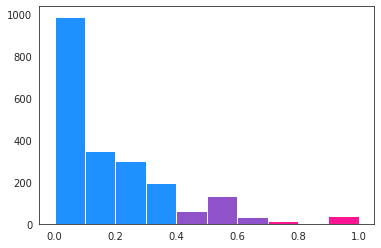

In [13]:
n, bins, patches = plt.hist(institution_gender_index['institution_gender_index'], 10)

for c, p in zip(bins, patches):
    if c >= 0 and c < 0.33:
        plt.setp(p, 'facecolor', 'DodgerBlue')
    elif c >= 0.33 and c < 0.66  :
        plt.setp(p, 'facecolor', '#8f52c9')
    elif c >= 0.66:
        plt.setp(p, 'facecolor', 'DeepPink')

plt.savefig("img/institution_gender_index_hist.png")